# Simulation Exercises

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

This notebook contains some exercises related to simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import jit, prange
import quantecon as qe

## Exercise

Suppose that the volatility of returns on an asset can be in one of two regimes — high or low.

The transition probabilities across states are as follows

![https://python-programming.quantecon.org/_static/lecture_specific/sci_libs/nfs_ex1.png](https://python-programming.quantecon.org/_static/lecture_specific/sci_libs/nfs_ex1.png)

  
For example, let the period length be one day, and suppose the current state is high.

We see from the graph that the state tomorrow will be

- high with probability 0.8  
- low with probability 0.2  


Your task is to simulate a sequence of daily volatility states according to this rule.

Set the length of the sequence to `n = 1_000_000` and start in the high state.

To test your code, evaluate the fraction of time that the chain spends in the low state.

If your code is correct, it should be about 2/3.

Implement a pure Python version and a Numba version, and compare speeds.

Hints:

- Represent the low state as 0 and the high state as 1.  

- To store integers in a NumPy array and then apply JIT compilation, use `x = np.empty(n, dtype=numba.int32)` or similar.

In [2]:
# Put your code here

In [3]:
for _ in range(20):
    print('Solution below!')

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


We let

- 0 represent “low”  
- 1 represent “high”

In [4]:
p, q = 0.1, 0.2  # Prob of leaving low and high state respectively

Here’s a pure Python version of the function

In [5]:
def compute_series(n):
    x = np.empty(n, dtype=np.int32)
    x[0] = 1  # Start in state 1
    for t in range(1, n):
        U = np.random.random()
        if x[t-1] == 0:
            x[t] = 1 if U < p else 0
        else: # x = 1
            x[t] = 0 if U < q else 1
    return x

In [6]:
n = 1_000_000

In [7]:
timer = qe.Timer()
with timer:
    x = compute_series(n)
elapsed_time = timer.elapsed  

0.50 seconds elapsed


In [8]:
print(np.mean(x == 0))  # Fraction of time x is in state 0

0.666832


Just for fun, let's add a plot that shows how the fraction of time spent in state zero converges to 2/3.

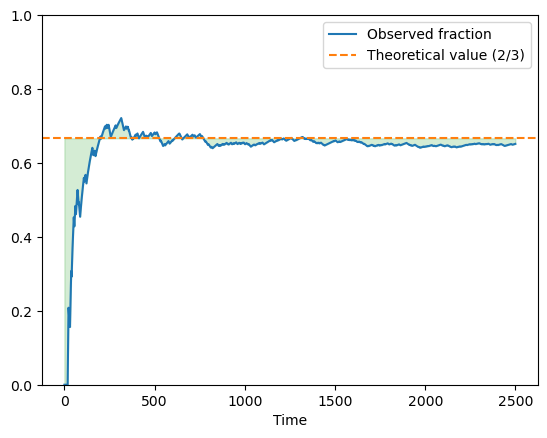

In [9]:
n_plot = 2500
x_plot = compute_series(n_plot)

# Calculate cumulative fraction of time in state 0 (unemployed)
cumulative_fraction = np.cumsum(x_plot == 0) / np.arange(1, n_plot + 1)

plt.figure()
plt.plot(cumulative_fraction, color='C0', label='Observed fraction')
plt.axhline(y=2/3, color='C1', linestyle='--', label='Theoretical value (2/3)')
plt.fill_between(range(n_plot), cumulative_fraction, 2/3, color='C2', alpha=0.2)
plt.xlabel('Time')

plt.ylim(0, 1)
plt.legend()
plt.show()

Now let's speed it up:

In [10]:
fast_compute_series = jit(compute_series)

Warm up:

In [11]:
fast_compute_series(n)

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

Now let's check the speed:

In [12]:
with timer:
    x = fast_compute_series(n)
elapsed_time_numba = timer.elapsed  

print(f"Numba is {elapsed_time / elapsed_time_numba} faster.")

0.01 seconds elapsed
Numba is 86.92684961214447 faster.


## Exercise


We consider using Monte Carlo to price a European call option.

The price of the option obeys 

$$
P = \beta^n \mathbb E \max\{ S_n - K, 0 \}
$$

where

1. $\beta$ is a discount factor,
2. $n$ is the expiry date,
2. $K$ is the strike price and
3. $\{S_t\}$ is the price of the underlying asset at each time $t$.

Suppose that `n, β, K = 20, 0.99, 100`.

Assume that the stock price obeys 

$$ 
\ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1}
$$

where 

$$ 
    \sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $\{\xi_t\}$ and $\{\eta_t\}$ are IID and standard normal.

(This is a stochastic volatility model, where the volatility $\sigma_t$ varies over time.)

Use the defaults `μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0`.

(Here `S0` is $S_0$ and `h0` is $h_0$.)

By generating $M$ paths $s_0, \ldots, s_n$, compute the Monte Carlo estimate 

$$
    \hat P_M 
    := \beta^n \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \beta^n \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
$$
    

If you can, use Numba to speed up loops.

If possible, use Numba-based multithreading (`parallel=True`) to speed it even
further.

In [13]:
# Put your code here

In [14]:
for _ in range(20):
    print('solution below')

solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below
solution below


With $s_t := \ln S_t$, the price dynamics become

$$
s_{t+1} = s_t + \mu + \exp(h_t) \xi_{t+1}
$$

Using this fact, the solution can be written as follows.

In [15]:
from numpy.random import randn
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@jit(parallel=True)
def compute_call_price_parallel(β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=M):
    current_sum = 0.0
    # For each sample path
    for m in prange(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

Let's also create non-parallel version for comparison

In [16]:
@jit(parallel=False)
def compute_call_price_serial(β=β,
                              μ=μ,
                              S0=S0,
                              h0=h0,
                              K=K,
                              n=n,
                              ρ=ρ,
                              ν=ν,
                              M=M):
    current_sum = 0.0
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)

    return β**n * current_sum / M

In [17]:
# Warm up both functions
_ = compute_call_price_parallel()
_ = compute_call_price_serial()

In [18]:
# Time serial version
timer = qe.Timer()
with timer:
    price_serial = compute_call_price_serial()
elapsed_time_serial = timer.elapsed
print(f"Serial price: {price_serial:.6f}")

8.87 seconds elapsed
Serial price: 187412.657013


In [19]:
# Time parallel version
with timer:
    price_parallel = compute_call_price_parallel()
elapsed_time_parallel = timer.elapsed
print(f"Parallel price: {price_parallel:.6f}")
print(f"Parallel is {elapsed_time_serial / elapsed_time_parallel:.2f}x faster")

0.90 seconds elapsed
Parallel price: 117979.626242
Parallel is 9.88x faster
